In [ ]:
!pip install lightning

In [ ]:
import gdown
import shutil
import os
from pathlib import Path
import pickle
import torch
from torch import nn, optim
import torchvision.models as models
import torch.nn.functional as F
import lightning as L
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

file_id = '1YHaxS8f6fQ5IMT3JJVeBH40eZSS-UC9h'
zip_file_path = '/content/Images.zip'
extract_folder = '/content/Images'

# Download and extract only if not already done
if not os.path.exists(extract_folder):
    gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', zip_file_path, quiet=False)
    shutil.unpack_archive(zip_file_path, extract_folder)
    print("Files extracted:", os.listdir(extract_folder))
else:
    print("Files already extracted.")

path = Path(extract_folder) / 'Images'


Files already extracted.


### Model Families in Medical Imaging

- **EfficientNet family** (e.g., `efficientnet_b0`, `efficientnet_b7`, `efficientnetv2_*`):  
  Known for their excellent accuracy-efficiency trade-off, these models are widely used in medical imaging for tasks like classification and segmentation due to their high performance with relatively low computational requirements.

- **DenseNet family** (e.g., `densenet121`, `densenet169`, `densenet201`):  
  DenseNets are popular in medical image analysis, especially `densenet121`, due to their ability to capture complex features through dense connectivity. They are used in applications like detecting abnormalities in X-rays and CT scans.

- **DeiT models** (e.g., `deit_base_patch16_224`, `deit_tiny_patch16_224`):  
  As Vision Transformers, DeiT models have shown promising results in medical imaging tasks. They handle complex visual patterns well, which makes them suitable for analyzing medical images that require attention to detail.


In [ ]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

#densenet121 = models.densenet121(pretrained=True)


In [ ]:
import torch
from torch import nn, optim
import torchvision.models as models
import torch.nn.functional as F
import lightning as L

class ImagenetTransferLearning(L.LightningModule):
    def __init__(self, input_size=(3, 224, 224)):
        super().__init__()

        # Initialize a pre-trained VGG16 model
        backbone = models.vgg16(pretrained=True)

        # Remove the final fully connected layers to use the model as a feature extractor
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # Freeze the feature extractor layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # Dynamically compute the number of input features for the classifier
        self._dummy_input = torch.zeros(1, *input_size)  # Create a dummy input tensor with the given size
        self._dummy_output = self.feature_extractor(self._dummy_input)  # Pass it through the feature extractor
        num_filters = self._dummy_output.numel()  # Get the total number of elements in the output tensor

        # Change the classifier for binary classification
        self.classifier = nn.Linear(num_filters, 1)  # Binary classification (1 output neuron)

    def forward(self, x):
        # Get the feature representations from the pre-trained VGG16 backbone
        representations = self.feature_extractor(x)  # Shape: (batch_size, 512, 7, 7)
        representations = representations.view(representations.size(0), -1)  # Flatten: (batch_size, num_filters)
        x = self.classifier(representations)  # Feed into the classifier
        return x  # Logits (no sigmoid applied yet)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits.squeeze(), y.float())  # BCEWithLogitsLoss
        self.log('train_loss', loss, prog_bar=True, on_step=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def on_epoch_end(self):
        # Log accuracy after each epoch
        self.log('train_acc_epoch', self.train_accuracy.compute(), prog_bar=True)
        self.log('val_acc_epoch', self.val_accuracy.compute(), prog_bar=True)

        # Reset metrics after logging
        self.train_accuracy.reset()
        self.val_accuracy.reset()

    # Optional: If you want to log accuracy during training
    def training_accuracy(self, preds, target):
        # Threshold the predictions to get binary outcomes (0 or 1)
        preds = torch.sigmoid(preds)  # Apply sigmoid to the logits
        preds = preds > 0.5  # Convert logits to binary predictions (0 or 1)
        return (preds == target).float().mean()  # Accuracy metric


In [ ]:
from PIL import Image
import os
from fastai.vision.all import *
# Paths

#path = Path("path/to/original/images")  # Replace with the path to your original images
save_path = Path("cropped/images")  # Replace with the path to save cropped images
save_path.mkdir(parents=True, exist_ok=True)

# Function to crop images into overlapping tiles
def crop_with_overlap(image_path, save_path, tile_size=(512, 512), stride=(256, 256)):
    img = Image.open(image_path)
    width, height = img.size
    label = image_path.parent.name  # Extract label from parent folder
    class_save_path = save_path / label
    class_save_path.mkdir(parents=True, exist_ok=True)

    for i in range(0, width - tile_size[0] + 1, stride[0]):
        for j in range(0, height - tile_size[1] + 1, stride[1]):
            left = i
            upper = j
            right = left + tile_size[0]
            lower = upper + tile_size[1]
            tile = img.crop((left, upper, right, lower))
            tile.save(class_save_path / f"{image_path.stem}_tile_{i}_{j}.jpg")

# Crop images into overlapping tiles
tile_size = (512, 512)
stride = (256, 256)

image_files = get_image_files(path)
for image_file in image_files:
    crop_with_overlap(image_file, save_path, tile_size=tile_size, stride=stride)

# Verify cropped images
sliced_image_files = get_image_files(save_path)
print(f"Total cropped images: {len(sliced_image_files)}")

Total cropped images: 5742


In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset


# Load the dataset
dataset = datasets.ImageFolder(root=save_path)

# Split the dataset into training and validation sets (e.g., 80/20 split)
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Define the augmentations (only for training set)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),  # Random crop and resize to 256x256
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(30),      # Random rotation
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Define transform for the validation set (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),   # Resize to 256x256 without augmentation
    transforms.ToTensor(),
])

# Apply the transformations to the respective subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataset = datasets.ImageFolder(root=save_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=path, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Now your DataLoader is ready to use


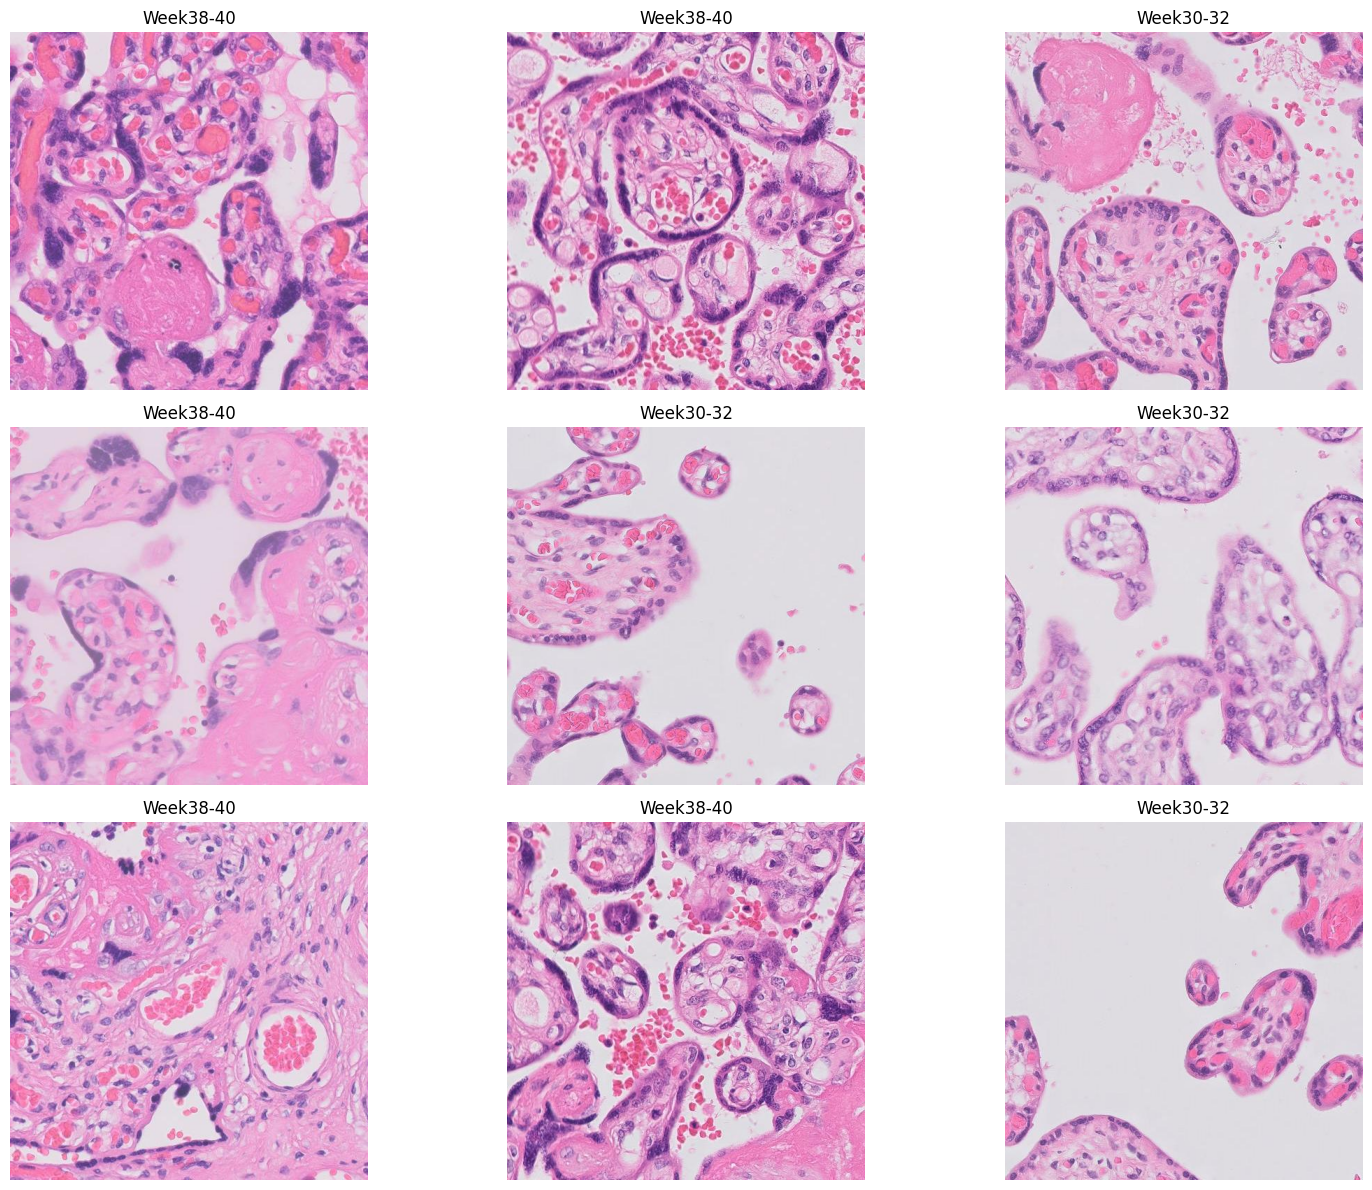

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the transform and dataset
transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
dataset = datasets.ImageFolder(root=save_path, transform=transform)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get a batch of 20 images and labels
images, labels = next(iter(data_loader))
images, labels = images[:9], labels[:9]

# Plot function
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    for img, label, ax in zip(images, labels, axes.flatten()):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display images
show_images(images, labels, dataset.classes)


In [ ]:
# Split the dataset into training and validation sets (80% train, 20% validation)
import lightning as L
# train_size = int(0.001 * len(dataset))
# val_size = len(dataset) - train_size
# # len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create DataLoaders for the training and validation sets
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model
model = ImagenetTransferLearning()
trainer = L.Trainer(limit_train_batches=1000,log_every_n_steps=321, max_epochs=3)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: 
  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | feature_extractor | Sequential | 14.7 M | train
1 | classifier        | Linear     | 25.1 K | train
---------------------------------------------------------
25.1 K    Trainable params
14.7 M    Non-trainable params
14.7 M    Total params
58.959    Total estimated model params size (MB)
35        Modules in train mode
0         

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Evaluation with confusion matrix and accuracy
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            preds = torch.sigmoid(outputs).squeeze().round()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Create a DataLoader for evaluation (optional)
eval_dataloader = val_loader
evaluate_model(model, eval_dataloader)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Evaluation with multiple thresholds
def evaluate_model_with_thresholds(model, dataloader, thresholds=np.arange(0.1, 1.0, 0.1)):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()
            all_labels.extend(labels.tolist())
            all_preds.extend(probs.tolist())

    best_threshold = 0.5
    best_metric = 0
    metrics = {}

    for threshold in thresholds:
        # Apply threshold
        preds = [1 if prob >= threshold else 0 for prob in all_preds]

        # Calculate metrics
        accuracy = accuracy_score(all_labels, preds)
        f1 = f1_score(all_labels, preds)  # You could also use precision, recall, etc.

        # Store metrics
        metrics[threshold] = {'accuracy': accuracy, 'f1_score': f1}

        # Choose the threshold based on the metric you prioritize (e.g., F1 score)
        if f1 > best_metric:
            best_metric = f1
            best_threshold = threshold

    # Output metrics and chosen threshold
    print(f"Best Threshold: {best_threshold:.2f} with F1 Score: {best_metric:.2f}")

    # Confusion Matrix for best threshold
    best_preds = [1 if prob >= best_threshold else 0 for prob in all_preds]
    cm = confusion_matrix(all_labels, best_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return best_threshold, metrics

# Example usage
best_threshold, metrics = evaluate_model_with_thresholds(model, eval_dataloader)

